In [ ]:
DATA_PATH = r'/home/luis-felipe/Uncertainty_Estimation/data'
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = r'/home/luis-felipe/Uncertainty_Estimation/torch_models'
PATH_trainer = r'/home/luis-felipe/Uncertainty_Estimation/torch_models/trainer'

In [2]:
import os
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import cifar_data

In [5]:
from uncertainty.MonteCarlo_Dropout import MonteCarloDropout
from uncertainty.ensemble import Ensemble
import uncertainty.metrics as metrics
from uncertainty import TestAugmentation as TTA


## um

In [6]:
N_ENS = 4
model_path = PATH_MODELS
MODEL_ARC = 'VGG_16'
DATA = 'Cifar100'
NAME = 'VGG16_100_ensemble_0.pt'#MODEL_ARC +'_' + DATA 

data = cifar_data.__dict__[DATA](data_dir = DATA_PATH)
model_class = models.__dict__[MODEL_ARC]

model_path = PATH_MODELS#os.path.join(PATH_MODELS,MODEL_ARC)
weights_path = os.path.join(model_path,NAME)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
model = model_class(num_classes = data.n_classes).to(dev)
model.eval()
model.softmax = True
state_dict = torch.load(weights_path)
model.load_state_dict(state_dict)
TE.model_acc(model,data.test_dataloader)

71.51

In [8]:
model_tta = TTA.TTA(model,N_ENS).to(dev)
TE.model_acc(model_tta,data.test_dataloader)

72.33

In [9]:
import copy
trans = copy.copy(model_tta.transforms)
for t in trans:
    model_tta.transforms = [t]
    print(f'transform = {t}')
    print(f'Acc = {TE.model_acc(model_tta,data.test_dataloader)}')

transform = <function hflip at 0x7f43e9a67f70>
Acc = 72.45
transform = <uncertainty.TestAugmentation.Scale object at 0x7f43b5028610>
Acc = 71.63
transform = <uncertainty.TestAugmentation.Scale object at 0x7f43b5028670>
Acc = 71.63
transform = <uncertainty.TestAugmentation.Rotate object at 0x7f43b50286d0>
Acc = 66.14
transform = <uncertainty.TestAugmentation.Rotate object at 0x7f43b5028730>
Acc = 66.53
transform = <uncertainty.TestAugmentation.Multiply object at 0x7f43b5028790>
Acc = 71.1
transform = <uncertainty.TestAugmentation.Multiply object at 0x7f43b50287f0>
Acc = 71.74
transform = <uncertainty.TestAugmentation.Add object at 0x7f43b5028850>
Acc = 71.45
transform = <uncertainty.TestAugmentation.Add object at 0x7f43b50288b0>
Acc = 71.33
transform = <uncertainty.TestAugmentation.FiveCrop object at 0x7f43b5028910>
Acc = 71.36


In [10]:
model_tta.use_main = False
for t in trans:
    model_tta.transforms = [t]
    print(f'transform = {t}')
    print(f'Acc = {TE.model_acc(model_tta,data.test_dataloader)}')

transform = <function hflip at 0x7f43e9a67f70>
Acc = 71.64
transform = <uncertainty.TestAugmentation.Scale object at 0x7f43b5028610>
Acc = 70.66
transform = <uncertainty.TestAugmentation.Scale object at 0x7f43b5028670>
Acc = 68.82
transform = <uncertainty.TestAugmentation.Rotate object at 0x7f43b50286d0>
Acc = 39.15
transform = <uncertainty.TestAugmentation.Rotate object at 0x7f43b5028730>
Acc = 39.93
transform = <uncertainty.TestAugmentation.Multiply object at 0x7f43b5028790>
Acc = 69.77
transform = <uncertainty.TestAugmentation.Multiply object at 0x7f43b50287f0>
Acc = 70.92
transform = <uncertainty.TestAugmentation.Add object at 0x7f43b5028850>
Acc = 71.49
transform = <uncertainty.TestAugmentation.Add object at 0x7f43b50288b0>
Acc = 71.34
transform = <uncertainty.TestAugmentation.FiveCrop object at 0x7f43b5028910>
Acc = 69.96


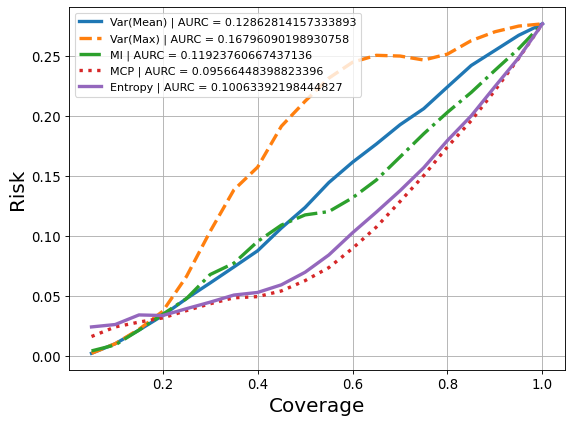

In [12]:
RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.plot_RC(aurc = True)

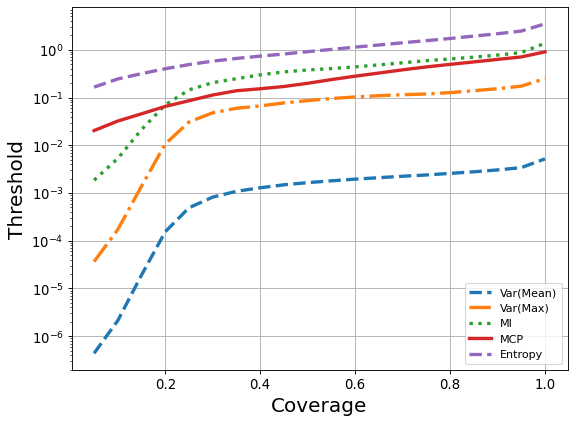

In [13]:
RC.plot_thresholds(normalize = False)
plt.yscale('log')

In [14]:
import pandas as pd
df = pd.DataFrame(index = RC.d_uncs.keys(),columns=RC.d_uncs.keys())


In [15]:
from scipy.stats import spearmanr
for name,un in RC.d_uncs.items():
    for name_2,un_2 in RC.d_uncs.items():
        df[name][name_2] = spearmanr(un.cpu().numpy(),un_2.cpu().numpy()).correlation

In [16]:
df

,Var(Mean),Var(Max),MI,MCP,Entropy
Var(Mean),1,0.895848,0.928688,0.834673,0.798454
Var(Max),0.895848,1,0.817011,0.653395,0.652114
MI,0.928688,0.817011,1,0.892936,0.908504
MCP,0.834673,0.653395,0.892936,1,0.978602
Entropy,0.798454,0.652114,0.908504,0.978602,1
